Run this script to compute or plot potential energy surface color-coded for photonic/excitonic contribution for different cavity parameters.

In [1]:
### Import all libraries and define various parameters here!
import numpy as np
from polaritonic import polaritonic
from numpy import linalg as LA
import math
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 13

The following cell will actually compute the derivative coupling and write it to a file.  You can change the $\gamma$ parameter and the filename (via $prefix$) here!

In [7]:
ri_init = -0.66156
vi_init = 3.3375e-5
### lifetime
gamp = 1.0
gam_diss_np = gamp * 1e-3 / 27.211

### photonic mode energy in eV
omp = 2.45
### convert to a.u.
omc = omp/27.211
### coupling strength in eV
gp = 0.02
gc = gp/27.211

au_to_ps = 2.4188e-17 * 1e12

### get prefix for data file names
prefix = "gam_1.0"
### filename to wrote PES to
pes_fn = "Data/" + prefix + '_pes.txt'
### filename to write photonic contributions of each state to
pc_fn = "Data/" + prefix + '_photon_contribution.txt'
filename = prefix + ".eps"

options = {
        'Number_of_Photons': 1,
        'Complex_Frequency': True,
        'Photon_Energys': [omc],
        'Coupling_Strengths': [gc], 
        'Photon_Lifetimes': [gam_diss_np],
        'Initial_Position': ri_init,
        'Initial_Velocity': vi_init,
        'Mass': 1009883,
        ### temperature in a.u.
        'Temperature': 0.00095,
        ### friction in a.u.
        'Friction': 0.000011,
        ### specify initial state as a human would, not a computer...
        ### i.e. 1 is the ground state... it will be shifted down by -1 so
        ### that it makes sense to the python index convention
        'Initial_Local_State': 3
        
        }

### instantiate
polt = polaritonic(options)
### write forces and derivative coupling
polt.Write_PES(pes_fn, pc_fn)


1

Once the derivative coupling has been written to a file (or several have been written to a file), you can parse the files and plot them with the following cell!

/Users/jay/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


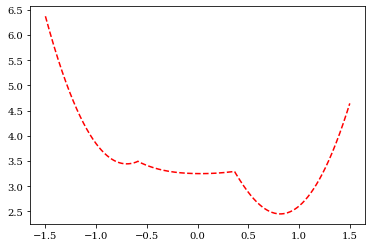

In [5]:
pes_50 = np.loadtxt("Data/gam_50.0_pes.txt",dtype=complex)
#pes_1 = np.loadtxt("Data/gam_1.0_pes.txt", dtype=complex)
#plt.plot(pes_1[:,0], 27.211*np.abs(pes_1[:,2]) , 'blue')
plt.plot(pes_50[:,0], 27.211*np.abs(pes_50[:,2]), 'r--')
#plt.xlim(-0.75,-0.45)
#plt.plot(pes_v[:,0], 27.211*np.real(pes_v[:,3]))
plt.show()


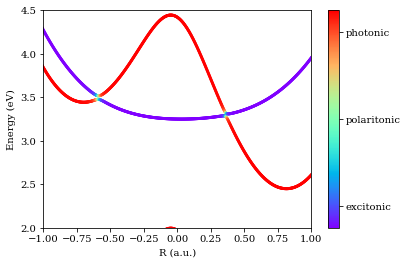

In [12]:
pes_v = np.loadtxt(pes_fn, dtype=complex)
pc_v = np.loadtxt(pc_fn,dtype=complex)


### read text file



fig, ax = plt.subplots()
cm = plt.cm.get_cmap('rainbow')
im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,1]), c=pc_v[:,1],cmap=cm, s=4) 
im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,2]), c=pc_v[:,2],cmap=cm, s=4) 
im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,3]), c=pc_v[:,3],cmap=cm, s=4)
#im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,4]), c=pc_v[:,4],cmap=cm, s=4)
cbar = fig.colorbar(im, ticks=[0.1, 0.5, 0.9])
cbar.ax.set_yticklabels(['excitonic', 'polaritonic', 'photonic'])
plt.xlim(-1.,1.)
plt.ylim(2.0,4.5)
plt.xlabel("R (a.u.)")
plt.ylabel("Energy (eV)")
plt.savefig(filename)
plt.show()

